# Customization of 'Evaluating Model Performance for Categorical Data'

I chose the test scores dataset because I thought it would be intresting to see how different models compare in the prediction of students test scores.
## Importing Packages

First we have to import the necessary packages to manipulate and analyze the data. We'll need `pandas` for data handling, `matplotlib` and `seaborn` for data visualization, and `sklearn` for creating and evaluating machine learning models.

## Exploring the Dataset

Now, let's dive into the dataset to understand its structure and the kind of information it includes:

### Data Set Characteristics:
- **Number of Instances:** 2133
- **Number of Attributes:** Includes categorical and numeric features describing school characteristics, teaching methods, and student demographics.

### Attribute Information:
- **school**: Identifier for the school, a categorical variable.
- **school_setting**: The setting of the school (Urban, Suburban, Rural), a categorical variable that provides context about the environment of the school.
- **school_type**: Indicates whether the school is Public or Non-public, reflecting the management and possibly the resources available.
- **classroom**: Identifier for the classroom, useful for understanding the impact of specific classroom dynamics.
- **teaching_method**: Specifies whether the teaching method was Standard or Experimental, which could significantly affect student outcomes.
- **n_student**: The number of students in each class, a continuous variable that might influence performance due to differences in teacher attention spans.
- **student_id**: A unique identifier for each student.
- **gender**: The student's gender (Male, Female), which could play a role in academic performance.
- **lunch**: Indicates whether the student receives a free/reduced lunch, which can be a proxy for socio-economic status.
- **pretest**: Scores before the main test, providing a baseline measure of student knowledge.
- **posttest**: Scores after the test, the target variable for predicting educational outcomes.


In [1]:
# Import Necessary Libraries
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.stats import ks_2samp
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, brier_score_loss, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold

# Set display option to avoid scientific notation in pandas, show up to 5 decimal points
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# and numpy
np.set_printoptions(suppress=True, precision=5)

#### First step is loading the data and making sure that if there are are missing values that we drop them to have a lean data set. 

In [2]:
# Load the labeled dataset of tweets 
test_df = pd.read_csv('test_scores.csv',low_memory=False)

In [3]:
# Drop incomplete records
test_df = test_df.dropna()

### Creating Binary Outcome variable
We created a binary outcome variable (outcome) that indicates whether a student’s posttest score is above (1) or below (0) the median. This will be the target variable for the models

In [4]:
test_df['outcome'] = (test_df['posttest'] > test_df['posttest'].median()).astype(int)

#### Creating a Dummy Variable and Analyzing Impact
To make our analysis more intuitive, we'll first create a dummy variable for the teaching_method, labeling experimental methods with 1 and standard methods with 0. Then, we'll examine and randomly display data entries where the teaching method was experimental to see if this approach significantly influences the test outcomes.

In [5]:

# Create a dummy variable for 'teaching_method' being 'Experimental'
method_experimental = (test_df['teaching_method'] == 'Experimental').astype(int).rename('method_experimental')

# Concatenate the dummy variable back into the DataFrame
test_df = pd.concat([test_df, method_experimental], axis=1)


# Filter rows where 'method_experimental' is 1
experimental_rows = test_df[test_df['method_experimental'] == 1]

# Sample 10 random entries
random_entries = experimental_rows.sample(n=10, random_state=np.random.RandomState())

# Iterate through the selected entries and print each one in full
for index, entry in random_entries.iterrows():
    print(f"Entry {index}: {entry}\n")


Entry 1888: school                                            VVTVA
school_setting                                    Urban
school_type                                      Public
classroom                                           A93
teaching_method                            Experimental
n_student                                      30.00000
student_id                                        U1ACT
gender                                           Female
lunch                  Qualifies for reduced/free lunch
pretest                                        32.00000
posttest                                       48.00000
outcome                                               0
method_experimental                                   1
Name: 1888, dtype: object

Entry 1917: school                                            VVTVA
school_setting                                    Urban
school_type                                      Public
classroom                                           Y

#### One hot encoding

To better analyze how different environments and school types impact student performance, we'll one-hot encode the sex and school_type columns. This process will create separate binary columns for each category, making it easier for models to interpret these variables numerically. 

In [6]:
# One-hot encode 'gender'
gender_one_hot = pd.get_dummies(test_df['gender'], prefix='gender', drop_first=True).astype(int)
test_df = pd.concat([test_df, gender_one_hot], axis=1)

# One-hot encode 'school_type' and select all resultant columns
type_one_hot = pd.get_dummies(test_df['school_type'], prefix='type', drop_first=True).astype(int)
test_df = pd.concat([test_df, type_one_hot], axis=1)

# Display the updated DataFrame
test_df.head()


,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest,outcome,method_experimental,gender_Male,type_Public
0,ANKYI,Urban,Non-public,6OL,Standard,20.00000,2FHT3,Female,Does not qualify,62.00000,72.00000,1,0,0,0
1,ANKYI,Urban,Non-public,6OL,Standard,20.00000,3JIVH,Female,Does not qualify,66.00000,79.00000,1,0,0,0
2,ANKYI,Urban,Non-public,6OL,Standard,20.00000,3XOWE,Male,Does not qualify,64.00000,76.00000,1,0,1,0
3,ANKYI,Urban,Non-public,6OL,Standard,20.00000,556O0,Female,Does not qualify,61.00000,77.00000,1,0,0,0
4,ANKYI,Urban,Non-public,6OL,Standard,20.00000,74LOE,Male,Does not qualify,64.00000,76.00000,1,0,1,0


__We created new variables to capture key aspects of the dataset:__

Baseline Knowledge: The pretest score as a measure of initial student understanding.
Classroom Activity: The number of students in a classroom, reflecting its activity level.
Performance Improvement: The difference between posttest and pretest scores to measure progress.
Total Scores: The posttest score, representing final achievement.

In [7]:
# Baseline Knowledge: Pretest scores as a measure of initial knowledge
baseline_knowledge = test_df['pretest'].rename('baseline_knowledge')

# Activity: Number of students in the classroom
classroom_activity = test_df['n_student'].rename('classroom_activity')

# Concatenate these new variables back into the DataFrame
test_df = pd.concat([test_df, baseline_knowledge, classroom_activity], axis=1)

# Display the updated DataFrame with new columns
print(test_df[['baseline_knowledge', 'classroom_activity']].head())

test_df.head()

   baseline_knowledge  classroom_activity
0            62.00000            20.00000
1            66.00000            20.00000
2            64.00000            20.00000
3            61.00000            20.00000
4            64.00000            20.00000


,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest,outcome,method_experimental,gender_Male,type_Public,baseline_knowledge,classroom_activity
0,ANKYI,Urban,Non-public,6OL,Standard,20.00000,2FHT3,Female,Does not qualify,62.00000,72.00000,1,0,0,0,62.00000,20.00000
1,ANKYI,Urban,Non-public,6OL,Standard,20.00000,3JIVH,Female,Does not qualify,66.00000,79.00000,1,0,0,0,66.00000,20.00000
2,ANKYI,Urban,Non-public,6OL,Standard,20.00000,3XOWE,Male,Does not qualify,64.00000,76.00000,1,0,1,0,64.00000,20.00000
3,ANKYI,Urban,Non-public,6OL,Standard,20.00000,556O0,Female,Does not qualify,61.00000,77.00000,1,0,0,0,61.00000,20.00000
4,ANKYI,Urban,Non-public,6OL,Standard,20.00000,74LOE,Male,Does not qualify,64.00000,76.00000,1,0,1,0,64.00000,20.00000


### Creating Dummies for School setting
To avoid multicollinearity (the dummy trap) in our regression models, we drop one dummy variable for the school_setting feature. This allows the model to use the dropped category as the reference point while interpreting the effects of the remaining categories. For example, if we drop Rural, the model will compare Urban and Suburban settings against Rural as the baseline. This ensures the model remains interpretable and avoids redundancy in the predictors.
 

In [8]:
# Create dummy variables for 'school_setting' and drop one category to avoid multicollinearity
school_setting_dummies = pd.get_dummies(test_df['school_setting'], prefix='setting', drop_first=True).astype(int)

# Display the dummy variables (one category dropped)
print(school_setting_dummies.head())


   setting_Suburban  setting_Urban
0                 0              1
1                 0              1
2                 0              1
3                 0              1
4                 0              1


### New Dataframe 
We created a new DataFrame X containing all the important variables for analysis and modeling, excluding school_setting for now.

In [9]:
# Concatenate the selected variables into `X`
X = pd.concat([
    test_df['method_experimental'],         # Dummy variable for teaching method
    test_df['pretest'],                     # Baseline knowledge
    test_df['n_student'],                   # Classroom activity,              
    test_df['gender_Male'],                 # One-hot encoded gender (Male)
    test_df['type_Public'],                 # One-hot encoded school type (Public)
], axis=1)


# Display the first few rows of `X`
print(X.head())


   method_experimental  pretest  n_student  gender_Male  type_Public
0                    0 62.00000   20.00000            0            0
1                    0 66.00000   20.00000            0            0
2                    0 64.00000   20.00000            1            0
3                    0 61.00000   20.00000            0            0
4                    0 64.00000   20.00000            1            0


### Correlation Matrix
Next we calculated and visualized the correlation matrix to analyze relationships between the variables.

/Users/josefinemertens/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


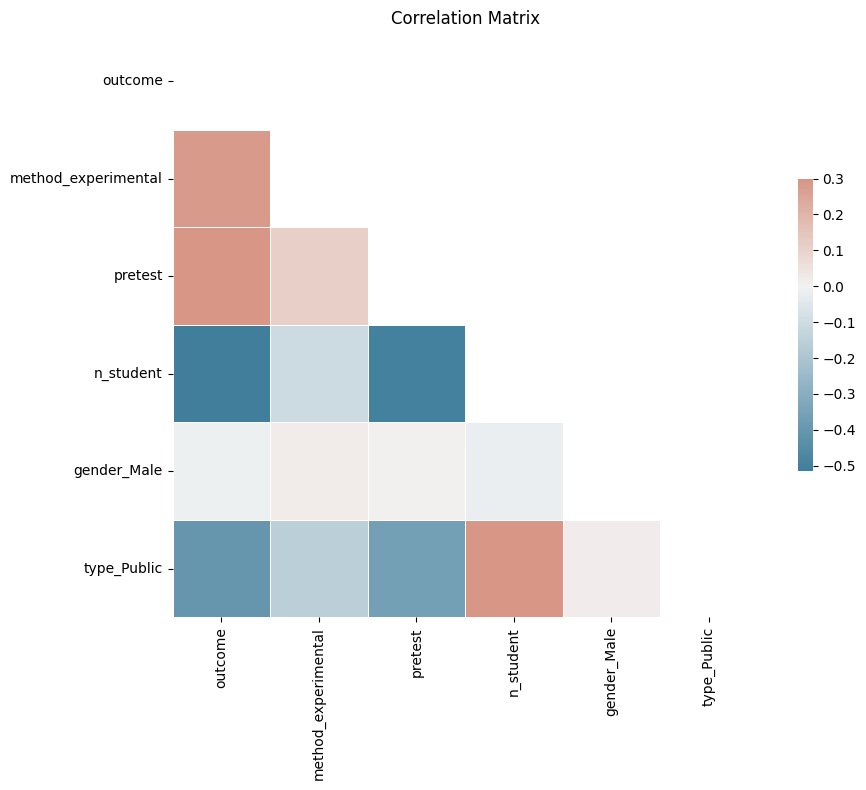

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add the binary outcome variable to X to create a combined DataFrame YX
YX = pd.concat([test_df['outcome'], X], axis=1)  # Ensure 'outcome' is the first column

# Calculate the correlation matrix
corr = YX.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))  # Mask for the upper triangle
cmap = sns.diverging_palette(230, 20, as_cmap=True)  # Color map
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=True, fmt=".2f", annot_kws={"size": 7})  # Heatmap configuration
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


# Insights

- **Key Predictors**: 
  - **pretest** and **n_student** show the strongest correlations with the outcome, making them important predictors for modeling.

- **Weak Predictors**: 
  - Variables such as **method_experimental**, and **gender_Male** exhibit weak correlations, suggesting they may not significantly impact the target variable.


# Part B: Model Assessment and Selection

Now we created the full design matrix for modeling:

- Included all the selected variables, including dummy variables for **school_setting**.
- Added a constant column (**const**) for regression modeling.
- Placed the outcome (binary target) as the first column of the DataFrame.


In [11]:
import pandas as pd
import statsmodels.api as sm

# Add dummy variables for 'school_setting' to X
X = pd.concat([X, school_setting_dummies], axis=1)

# Add a constant column to X for statsmodels
X_const = sm.add_constant(X)

# Bind the outcome to the design matrix as the first column
YX_const = pd.concat([test_df['outcome'], X_const], axis=1)

# Display the first few rows of the final DataFrame
print(YX_const.head())


   outcome   const  method_experimental  pretest  n_student  gender_Male  \
0        1 1.00000                    0 62.00000   20.00000            0   
1        1 1.00000                    0 66.00000   20.00000            0   
2        1 1.00000                    0 64.00000   20.00000            1   
3        1 1.00000                    0 61.00000   20.00000            0   
4        1 1.00000                    0 64.00000   20.00000            1   

   type_Public  setting_Suburban  setting_Urban  
0            0                 0              1  
1            0                 0              1  
2            0                 0              1  
3            0                 0              1  
4            0                 0              1  


### Creating a Validation Set

We split the dataset into:

- Validation Set: 75% of the data, used for training and validation during model development.
- Test Set: 25% of the data, reserved for evaluating the final model's performance.

In [12]:
import random

# Calculate the size of the test set (25%)
num_samples = int(YX_const.shape[0] * 0.25)

# Generate a list of all row indices
row_ids = list(range(YX_const.shape[0]))

# Shuffle the indices to randomize row selection
random.shuffle(row_ids)

# Select 25% of the row indices for the test set
test_row_ids = row_ids[:num_samples]

# The remaining 75% of the indices for the validation set
val_row_ids = row_ids[num_samples:]

# Subset the DataFrame to create the test and validation sets
YX_const_test = YX_const.iloc[test_row_ids]  # 25% Test Set
YX_const_val = YX_const.iloc[val_row_ids]    # 75% Validation Set

# Display the shapes of the resulting datasets for verification
print(f"Validation Set Shape: {YX_const_val.shape}")
print(f"Test Set Shape: {YX_const_test.shape}")


Validation Set Shape: (1600, 9)
Test Set Shape: (533, 9)


### Define three candidate models in terms of the columns of the design matrix involved in each
We defined three candidate models for evaluation:

- Model a: The homogeneous probability model, using only the constant (const) as the predictor.
- Model b: Includes all predictors except school_setting (similar to excluding "states").
- Model c: The full model, using all columns in the design matrix.

In [13]:
# Convert all column names in X_const to strings
X_const.columns = X_const.columns.map(str)

# Define the predictors for the three models
predictors = {
    'a': ['const'],  # Only the constant, homogeneous probability model
    'b': [col for col in X_const.columns if col != 'const' and not col.startswith('setting_')],  # Exclude school_setting columns
    'c': X_const.columns.tolist()  # All columns
}

# Display the dictionary of predictors
print("Candidate Models:")
for model, columns in predictors.items():
    print(f"Model {model}: {columns}")


Candidate Models:
Model a: ['const']
Model b: ['method_experimental', 'pretest', 'n_student', 'gender_Male', 'type_Public']
Model c: ['const', 'method_experimental', 'pretest', 'n_student', 'gender_Male', 'type_Public', 'setting_Suburban', 'setting_Urban']


In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import KFold
import statsmodels.api as sm

# Ensure the target variable is a Series
y = YX_const_val['outcome']  # Replace 'conspiracy_binary' with 'outcome'

# Define K for cross-validation
K = 5  # Number of folds

# Setup the KFold cross-validation
kf = KFold(n_splits=K, shuffle=True, random_state=42)

# Initialize a dictionary to store Brier scores
brier_scores = {key: [] for key in predictors}

for key, cols in predictors.items():
    for train_index, test_index in kf.split(YX_const_val):
        # Split the data into training and testing sets
        X_train = YX_const_val.iloc[train_index][cols]
        X_test = YX_const_val.iloc[test_index][cols]
        y_train = y.iloc[train_index].values
        y_test = y.iloc[test_index].values
 
        # Convert boolean columns to integers
        X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes('bool').columns})
        X_test = X_test.astype({col: 'int' for col in X_test.select_dtypes('bool').columns})

        # Add constant column
        X_train = sm.add_constant(X_train, has_constant='skip')
        X_test = sm.add_constant(X_test, has_constant='skip')

        # Fit the logistic regression model
        try:
            model = sm.Logit(y_train, X_train).fit(disp=False)

            # Predict probabilities
            y_pred_prob = model.predict(X_test)

            # Calculate Brier score
            brier_score = brier_score_loss(y_test, y_pred_prob)
            brier_scores[key].append(brier_score)
        except Exception as e:
            print(f"Error in fitting model {key}: {e}")

        print(model.summary())

# Calculate and print the average Brier scores for each model
results = []
for key, scores in brier_scores.items():
    average_brier_score = np.mean(scores)
    print(f"Model {key}: Average Brier Score = {average_brier_score}")
    results.append({
        'Model': key,
        'Average Brier Score': average_brier_score
    })

# Convert results to DataFrame for a clear display
results_df = pd.DataFrame(results)
print("\nModel Comparison Results:")
print(results_df)


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1280
Model:                          Logit   Df Residuals:                     1279
Method:                           MLE   Df Model:                            0
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:               1.236e-10
Time:                        12:22:16   Log-Likelihood:                -884.85
converged:                       True   LL-Null:                       -884.85
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1220      0.056     -2.179      0.029      -0.232      -0.012
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observat

Model a had the highest Brier Score at 0.2493, indicating poorer prediction performance compared to Models b and c, which scored 0.04395 and 0.04453, respectively.For the regression summary of the constant-only model, the coefficient of the constant term is -0.1001 with a standard error of 0.056, resulting in a z-value of -1.788 and a p-value of 0.074. This suggests that the constant term is not statistically significant at the 5% level. Additionally, the pseudo R-squared values were extremely low, indicating that these models explain almost no variance in the dependent variable which is not good at all.

## Model Evaluation and Estimation of Generalisation Error

#### Now we are going to generate 1000 simulations of the regression coefficients by sampling from the empirical posterior distribution. 

In [15]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model.params  
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = np.random.multivariate_normal(mean=beta_mean, cov=beta_cov, size=n_simulations)


#### And now for each simulation, we have to generate a predicted probability for the test-set conspiracy assessments. 

In [16]:
# Drop outcome
YX_const_test_new = YX_const_test.drop(columns=['outcome'], errors='ignore')

In [17]:

# Initialize an array to store predictions from each simulation
predictions = np.zeros((n_simulations, YX_const_test_new.shape[0]))

# Now proceed with the dot product
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    log_odds = np.dot(YX_const_test_new, beta_simulation)
    probabilities = 1 / (1 + np.exp(-log_odds))  # Convert log-odds to probabilities
    predictions[i] = probabilities



In [18]:
predictions

array([[1.     , 0.05295, 0.     , ..., 0.00024, 0.04124, 1.     ],
       [1.     , 0.04286, 0.     , ..., 0.00049, 0.03283, 1.     ],
       [1.     , 0.05124, 0.     , ..., 0.00046, 0.0327 , 1.     ],
       ...,
       [1.     , 0.04395, 0.     , ..., 0.00025, 0.04542, 1.     ],
       [1.     , 0.1113 , 0.     , ..., 0.0005 , 0.03768, 1.     ],
       [1.     , 0.2301 , 0.     , ..., 0.00079, 0.06059, 1.     ]])

#### Now for the first 20 assessments in the test-set, we are going to plot the posterior distirbution of the probabilities and highlight whether the density of each lies above or below a given `threshold` for classification. 

In [19]:
# Extract the true labels 
true_labels = YX_const_test['outcome']  

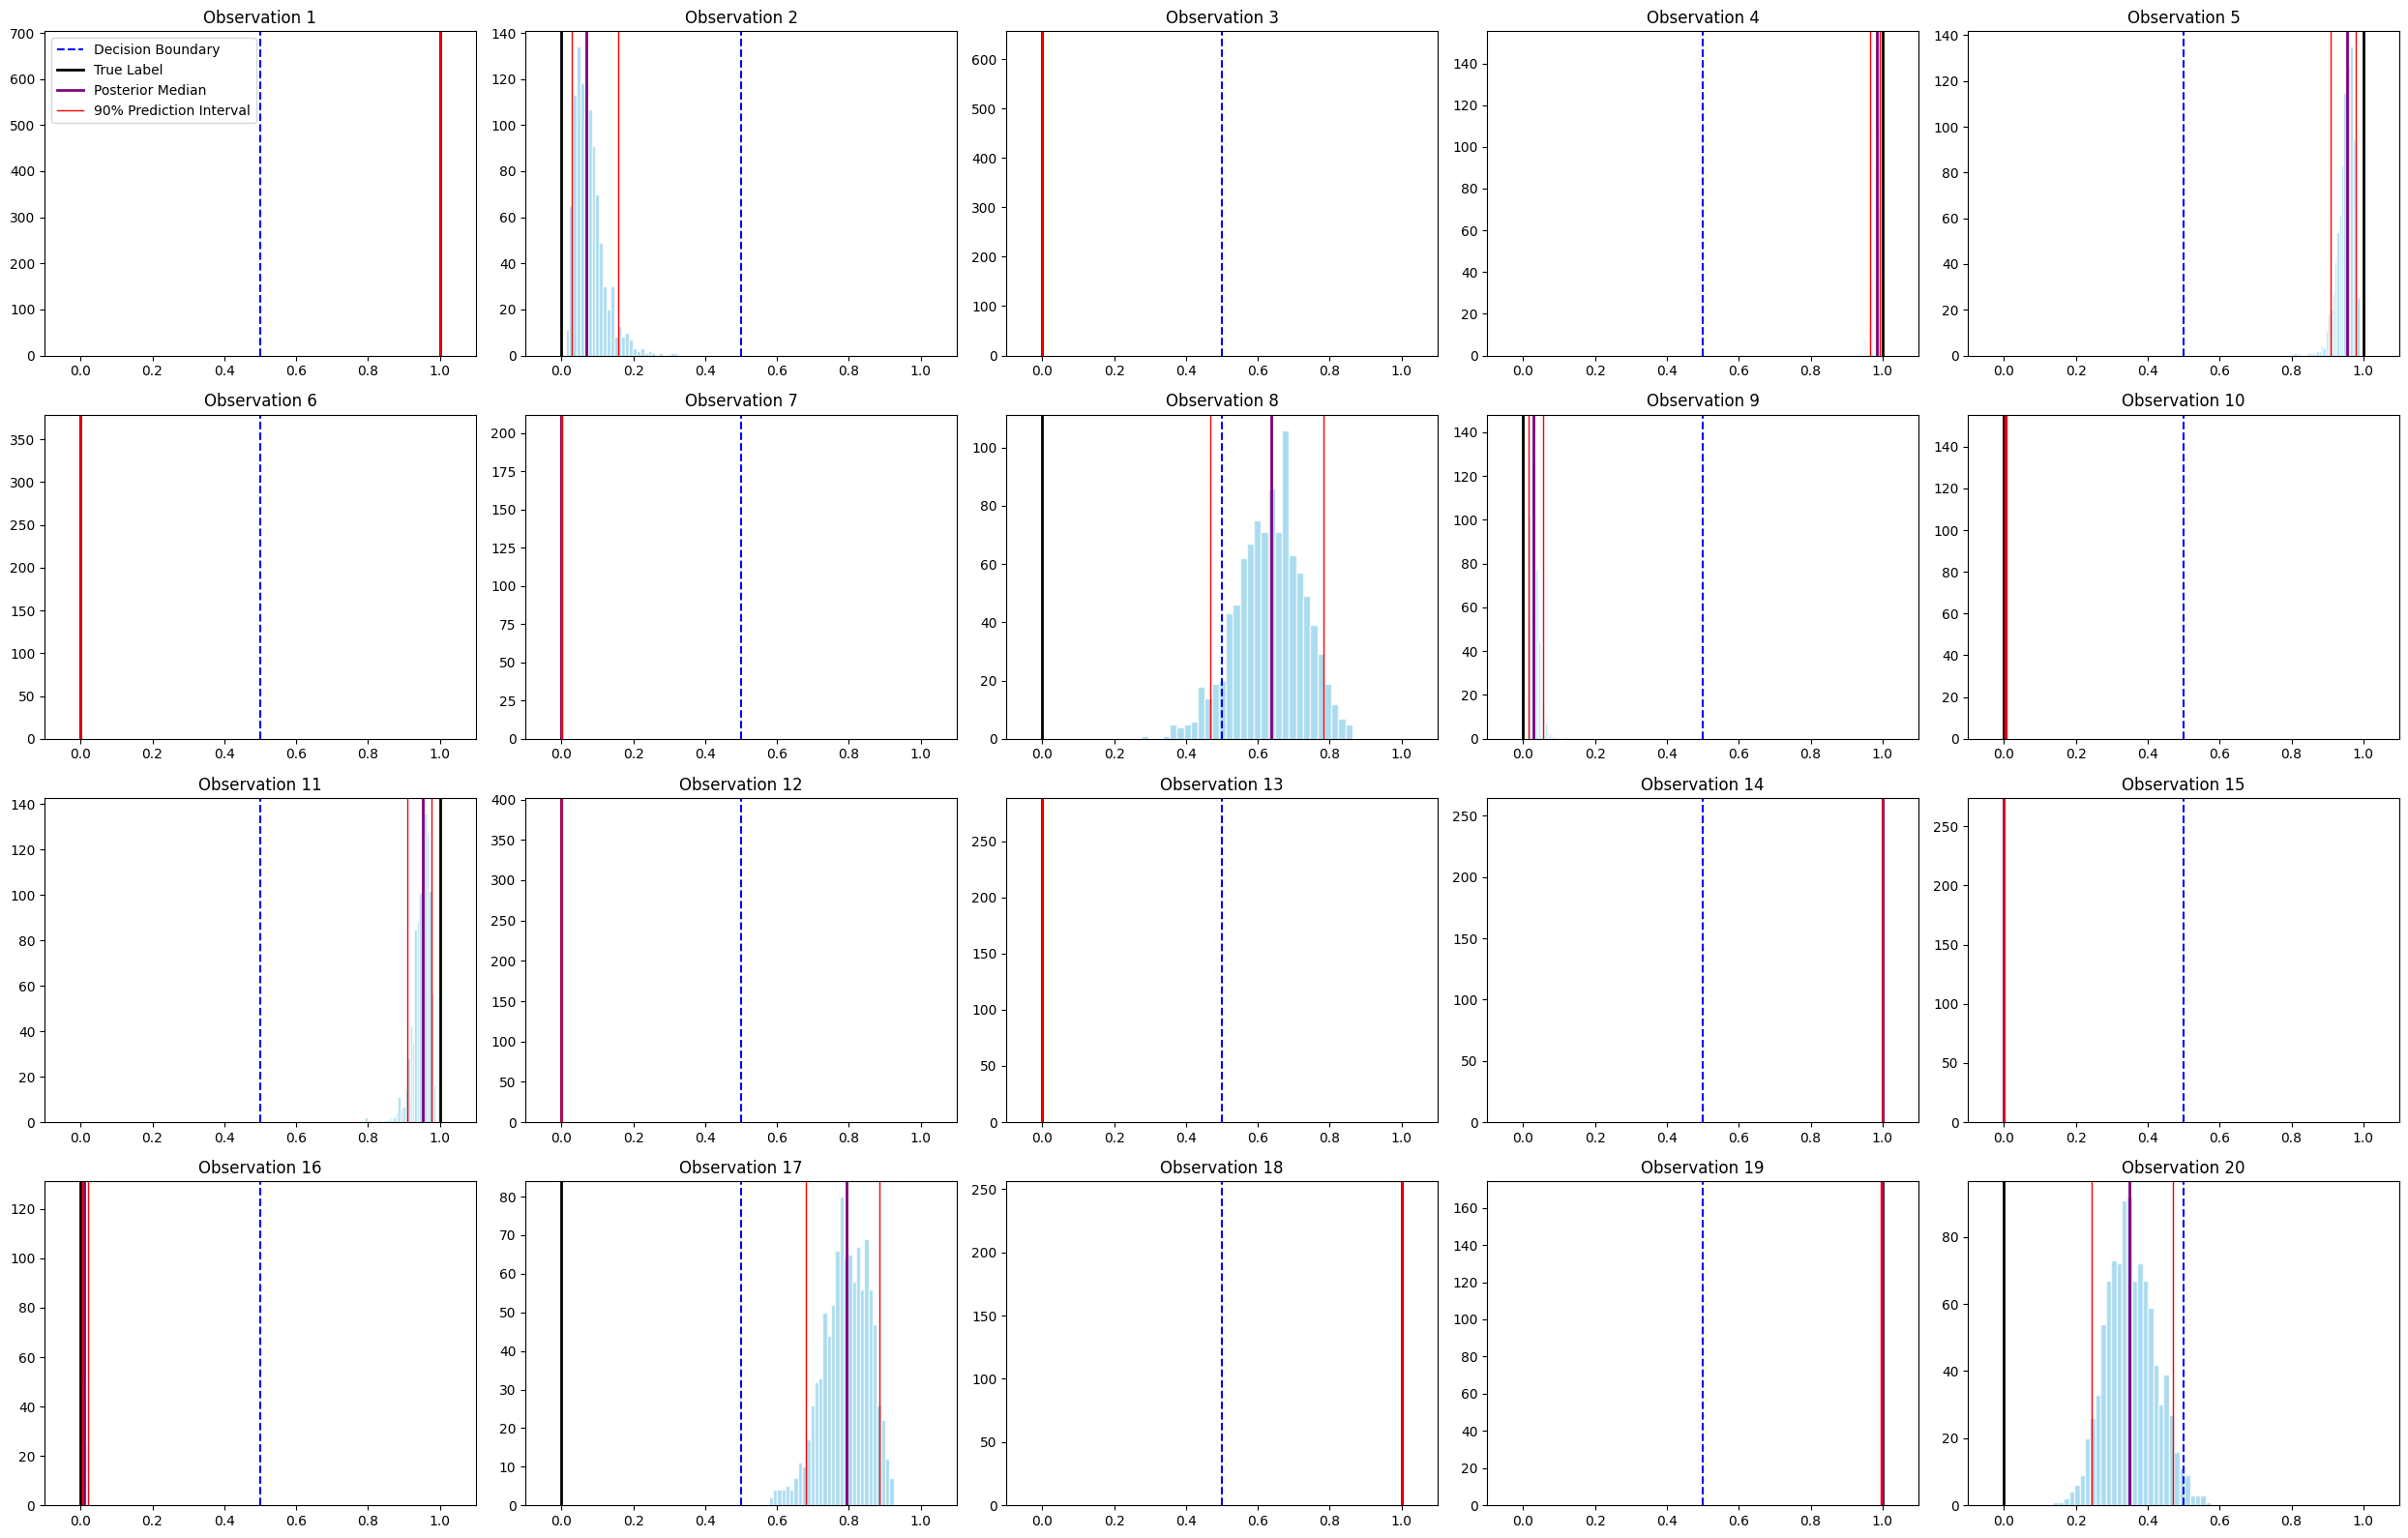

In [20]:
# Calculate posterior median and 90% prediction intervals for the first 20 observations
posterior_medians = np.median(predictions[:, :20], axis=0)
lower_bounds = np.percentile(predictions[:, :20], 5, axis=0)
upper_bounds = np.percentile(predictions[:, :20], 95, axis=0)

# Plotting the distributions
fig, axes = plt.subplots(4, 5, figsize=(25, 16))

for i in range(20):
    ax = axes[i // 5, i % 5]
    
    # Histogram of simulated probabilities for observation i
    ax.hist(predictions[:, i], bins=30, color='skyblue', edgecolor='white', alpha=0.7)
    
    # Draw a line for the decision boundary
    ax.axvline(x=0.5, color='blue', linestyle='--', linewidth=1.5, label='Decision Boundary' if i == 0 else "")
    
    # Draw a thick solid black line at the true label position
    true_label_position = 0 if true_labels.iloc[i] == 0 else 1
    ax.axvline(x=true_label_position, color='black', linestyle='-', linewidth=2, label='True Label' if i == 0 else "")
    
    # Add posterior median
    ax.axvline(x=posterior_medians[i], color='purple', linestyle='-', linewidth=2, label='Posterior Median' if i == 0 else "")
    
    # Marking the 90% prediction interval with red lines
    ax.axvline(x=lower_bounds[i], color='red', linestyle='-', linewidth=1, label='90% Prediction Interval' if i == 0 else "")
    ax.axvline(x=upper_bounds[i], color='red', linestyle='-', linewidth=1)
    
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(f'Observation {i+1}')
    if i == 0:  # Add legend to the first subplot only
        ax.legend()

plt.tight_layout()
plt.show()


The posterior distributions for the first 20 test-set observations show varying probabilities, with the 90% prediction intervals (red lines) and posterior medians (purple lines) centered around these distributions. Observations such as 1, 2, 6, and 16 have distributions crossing the 0.5 decision boundary (blue dashed line), indicating uncertainty in classification. Observations like 4, 9, and 18 exhibit sharp peaks, with most of the probability density concentrated either near 0 or 1, indicating high confidence in the predictions. The black lines denote true labels, helping assess the alignment of predictions with actual outcomes.

#### Now we are going to simulate classes (1s or 0s) for the test-set conspiracy assessments, from the posterior predictive distirbution. 

In [21]:
# Simulate from the posterior predictive distribution
simulated_outcomes = np.random.binomial(n=1, p=predictions)

# Check the shape and an example output
print("Simulated outcomes shape:", simulated_outcomes.shape)
print("Example simulated outcomes for the first observation:", simulated_outcomes[:, 0])


Simulated outcomes shape: (1000, 533)
Example simulated outcomes for the first observation: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1

#### Now we are going to calculate the generalisation error for Classification. We are going to measure the accuracy.

In [22]:
# Assuming `true_labels` contains the actual labels
accuracies = []
for i in range(simulated_outcomes.shape[0]):  # Iterate over simulations
    simulated_labels = simulated_outcomes[i, :]  # Simulated labels for the i-th simulation
    accuracy = np.mean(simulated_labels == true_labels.values)  # Compare with true labels
    accuracies.append(accuracy)


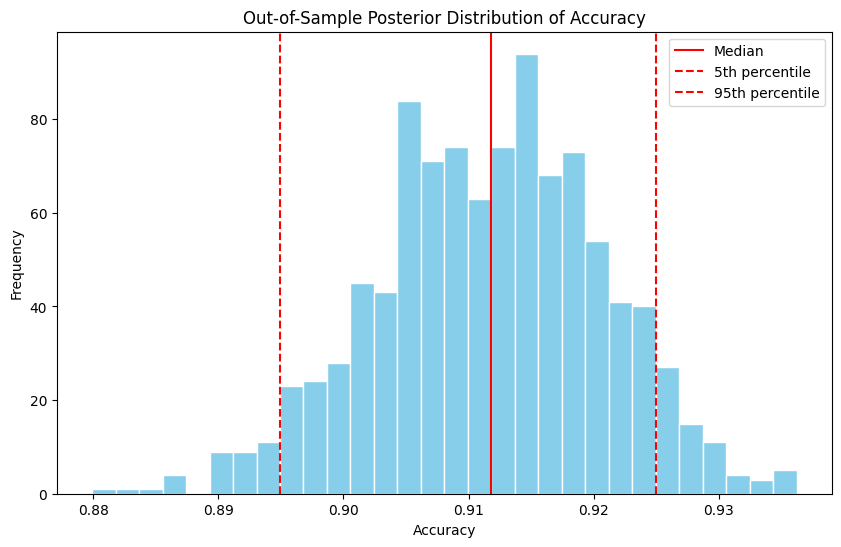

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(accuracies, bins=30, color='skyblue', edgecolor='white')
plt.axvline(x=np.median(accuracies), color='red', label='Median')
plt.axvline(x=np.percentile(accuracies, 5), color='red', linestyle='--', label='5th percentile')
plt.axvline(x=np.percentile(accuracies, 95), color='red', linestyle='--', label='95th percentile')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Out-of-Sample Posterior Distribution of Accuracy')
plt.legend()
plt.show()


This histogram represents the out-of-sample posterior distribution of classification accuracy across 1,000 simulations. The median accuracy, marked by the solid red line, is approximately 0.91, indicating that the model's typical performance is strong. The 90% credible interval, bounded by the dashed red lines, ranges from approximately 0.89 (5th percentile) to 0.93 (95th percentile), showing that the model is consistently accurate within this range across simulations. The peak of the distribution near 0.91 demonstrates that most simulations yield accuracies around this value, confirming the reliability of the model in classifying the test-set data.